## Italian Corona Tracker
    install git mkae a git folder go there then:
    type this into a folder (unix) git pull https://github.com/pcm-dpc/COVID-19
    or just download the data.
    
    This data is currently plotted here: http://opendatadpc.maps.arcgis.com/apps/opsdashboard/index.html#/b0c68bce2cce478eaac82fe38d4138b1
    
    Population Density: 
    https://sedac.ciesin.columbia.edu/data/set/gpw-v4-admin-unit-center-points-population-estimates-rev11/data-download

In [10]:
import sys, os, copy, pprint, glob
import datetime
import csv,random

#Make sure these libraries are installed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess

In [11]:
data_ud='../italy/COVID-19/'
p = subprocess.Popen(['git', 'pull'], cwd=data_ud)
p.wait()

0

In [3]:
#Makes geo queries a little more efficient
def interlace(lo, la, multiple=10):
    degx=lambda x:'%05d'%(int((x+180)*multiple)%(360*multiple))
    lon=degx(lo)
    lat=degx(la)
    l='-'.join(['%s%s'%(lon[i], lat[i]) for i in range(5)])
    return l

def interlace_query(lo, la, multiple=10):
    degx=lambda x:int(x*multiple)
    delta=0.5
    lonLst=set([degx(lo), degx(lo+delta), degx(lo-delta)])
    latLst=set([degx(la), degx(la+delta), degx(la-delta)])
    queryLst=set()
    for lon in lonLst:
        for lat in latLst:
            queryLst.add(interlace(lon/float(multiple), lat/float(multiple), multiple=multiple))
    return list(queryLst)
            
            
x,y=13.351017, 38.142266
interlace(x,y), interlace_query(x,y, multiple=1), interlace_query(x,y, multiple=10)

('00-12-91-38-31',
 ['00-00-12-91-37', '00-00-12-91-38', '00-00-12-91-27', '00-00-12-91-28'],
 ['00-12-91-28-81',
  '00-12-91-37-36',
  '00-12-91-37-86',
  '00-12-91-28-86',
  '00-12-91-38-81',
  '00-12-91-38-36',
  '00-12-91-38-86',
  '00-12-91-27-86',
  '00-12-91-38-31'])

In [ ]:
#Rebuilds pop density data
inp_pop = 'data/gpw_v4_admin_unit_center_points_population_estimates_rev11_ita.csv'
pop_df= pd.read_csv(inp_pop, header=0)[['NAME1', 'NAME2', 'NAME3','CENTROID_X', 'CENTROID_Y','UN_2020_DS','UN_2020_E', 'A65PLUSB','A70PLUSB','A75PLUSB']]
pop_df['lola_key_10'] = pop_df[['CENTROID_X', 'CENTROID_Y']].apply(lambda x: interlace(x[0], x[1], multiple=10), axis=1)
pop_df['lola_key'] = pop_df[['CENTROID_X', 'CENTROID_Y']].apply(lambda x: interlace(x[0], x[1], multiple=1), axis=1)
pop_df['65_plus_ratio']=pop_df['A65PLUSB']/pop_df['UN_2020_E']
lolakey_dict={}
for idx, rec in pop_df.iterrows():
    k=rec['lola_key']
    if not(k in lolakey_dict):lolakey_dict[k]=dict([(k,[]) for k in ['UN_2020_DS', '65_plus_ratio']])
    for val_key in ['UN_2020_DS', '65_plus_ratio']:
        val=rec[val_key]
        if not(np.isnan(val)) and val>0:
            lolakey_dict[k][val_key].append(val)

for k in lolakey_dict.keys():
    for val_key in ['UN_2020_DS', '65_plus_ratio']:
        lolakey_dict[k][val_key]=np.mean(lolakey_dict[k][val_key])
pop_df.to_csv('data/pop_data_%s.csv'%run_root)
pop_df.head(10)

In [ ]:
#Build all locations List Curate to make loc_lst_mapTo.csv
run_root='italy'
LL=['data', 'stato', 'codice_regione', 'denominazione_regione', 
    'codice_provincia', 'denominazione_provincia', 
    'sigla_provincia', 'lat', 'long', 'totale_casi']
get_LL=['codice_regione', 'denominazione_regione', 
    'codice_provincia', 'denominazione_provincia', 
    'sigla_provincia', 'lat', 'long']#, 'totale_casi']

pop_df=pd.read_csv('data/pop_data_%s.csv'%run_root, header=0)
locLst=[]
c_ud=data_ud+'dati-province/'
inp=c_ud+'dpc-covid19-ita-province.csv'
cor_data= pd.read_csv(inp, header=0)
cor_data.drop_duplicates(['codice_regione', 'denominazione_regione', 
                            'codice_provincia', 'denominazione_provincia', 
                          'sigla_provincia'], inplace=True)
cor_data.head(10)


In [ ]:
#Adds population data to italian corona data 
from scipy.spatial.distance import cdist

#'CENTROID_X', 'CENTROID_Y','UN_2020_DS', 'NAME3'
popdensityLst=[];distLst=[];over65Lst=[]
for idx, rec in cor_data.iterrows():
    y=[];age_ratio=[]
    qpoint=np.array([rec.long, rec.lat])
    for q in interlace_query(rec.long, rec.lat, multiple=1):
        if q in lolakey_dict:
            v=lolakey_dict[q]
            pop_d=v['UN_2020_DS']
            if pop_d==0:continue
            y.append(pop_d)
            age_ratio.append(v['65_plus_ratio'])
    if y:
        pop_dens=np.mean(y)
        popdensityLst.append(np.mean(y))
        over65Lst.append(np.mean(age_ratio))
    else:
        popdensityLst.append(0)
        over65Lst.append(0)
cor_data['pop_density']=np.array(popdensityLst)
cor_data['65_plus_ratio']=np.array(over65Lst) 

cor_data.to_csv('data/cor_data_%s.csv'%run_root)
cor_data.head(5) 

In [12]:
#denominazione_provincia	sigla_provincia
import math
run_root='italy'
c_ud=data_ud+'dati-province/'

mapto_df=pd.read_csv('data/cor_data_%s.csv'%run_root)
mapto_df.fillna(0, inplace=True)
d={}
locLst=[]

for inp in glob.glob(c_ud+'*.csv'):
    fn=os.path.basename(inp)
    if not('2020' in fn):continue
    file_date=fn.split('.')[0].split('-')[-1]
    cor_data= pd.read_csv(inp)
    cor_data.fillna(0, inplace=True)
    pop_densLst=[]
    plus65_ratioLst=[]
    us_df=cor_data
    d[file_date]={}
    total_cases=0
    for i, row in us_df.iterrows():
        sp=row['sigla_provincia']
        if not(sp):continue
        location='%s_%s'%(row['denominazione_regione'],row['denominazione_provincia'])
        pop_density=mapto_df.loc[(mapto_df['sigla_provincia']==sp)].values.tolist()[0][-2]
        plus65_ratio=mapto_df.loc[(mapto_df['sigla_provincia']==sp)].values.tolist()[0][-1]
        cases = 0 if row['totale_casi']==0 else row['totale_casi']
        d[file_date][location]=cases#math.log(cases)
        total_cases+=row['totale_casi']
        pop_densLst.append(pop_density)
        plus65_ratioLst.append(plus65_ratio)
dLst=list(d.keys())
dLst.sort()
df=pd.DataFrame(d, columns=dLst).fillna(0)


df['row_max']=df.max(axis=1)
df['pop_density']=np.array(pop_densLst)
df['65_plus_ratio']=np.array(plus65_ratioLst)

df.loc['total_counts', :] = df.sum(axis=0)
df=df.sort_values(by=['row_max'],ascending=False)
df.to_csv('data/%s_latest.csv'%run_root)


df.head(9)

,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,20200303,20200304,...,20200327,20200328,20200329,20200330,20200331,20200401,20200402,row_max,pop_density,65_plus_ratio
total_counts,0.0,312.0,370.0,622.0,822.0,1044.0,1560.0,1831.0,2421.0,2975.0,...,82763.0,88560.0,93783.0,97646.0,101387.0,105843.0,110238.0,110274.0,653606.067449,26.854788
Lombardia_Milano,0.0,8.0,8.0,15.0,29.0,30.0,46.0,58.0,93.0,145.0,...,7469.0,7783.0,8329.0,8676.0,8911.0,9522.0,10004.0,10004.0,5997.000048,0.289323
Lombardia_Bergamo,0.0,18.0,20.0,72.0,103.0,110.0,209.0,243.0,372.0,423.0,...,8060.0,8349.0,8527.0,8664.0,8803.0,9039.0,9171.0,9171.0,4584.886163,0.239340
Lombardia_Brescia,0.0,0.0,2.0,10.0,13.0,14.0,49.0,60.0,86.0,127.0,...,7305.0,7678.0,8013.0,8213.0,8367.0,8598.0,8757.0,8757.0,4584.886163,0.239340
Piemonte_Torino,0.0,3.0,3.0,2.0,11.0,11.0,49.0,6.0,7.0,11.0,...,3361.0,3658.0,3933.0,4150.0,4455.0,4711.0,4991.0,4991.0,8312.899055,0.269765
Lombardia_Cremona,0.0,53.0,57.0,91.0,123.0,136.0,214.0,223.0,287.0,333.0,...,3496.0,3605.0,3762.0,3788.0,3869.0,3941.0,3974.0,3974.0,5319.899184,0.272959
Emilia-Romagna_Piacenza,0.0,18.0,28.0,63.0,89.0,138.0,174.0,212.0,256.0,319.0,...,2276.0,2390.0,2475.0,2516.0,2635.0,2716.0,2765.0,2765.0,5319.899184,0.272959
Emilia-Romagna_Reggio nell'Emilia,0.0,0.0,0.0,0.0,1.0,4.0,7.0,8.0,14.0,20.0,...,1861.0,1996.0,2146.0,2208.0,2307.0,2553.0,2665.0,2665.0,4235.915140,0.243959
Lombardia_Monza e della Brianza,0.0,3.0,4.0,5.0,6.0,6.0,6.0,8.0,9.0,11.0,...,1948.0,2086.0,2265.0,2362.0,2462.0,2543.0,2633.0,2633.0,4702.420919,0.268026


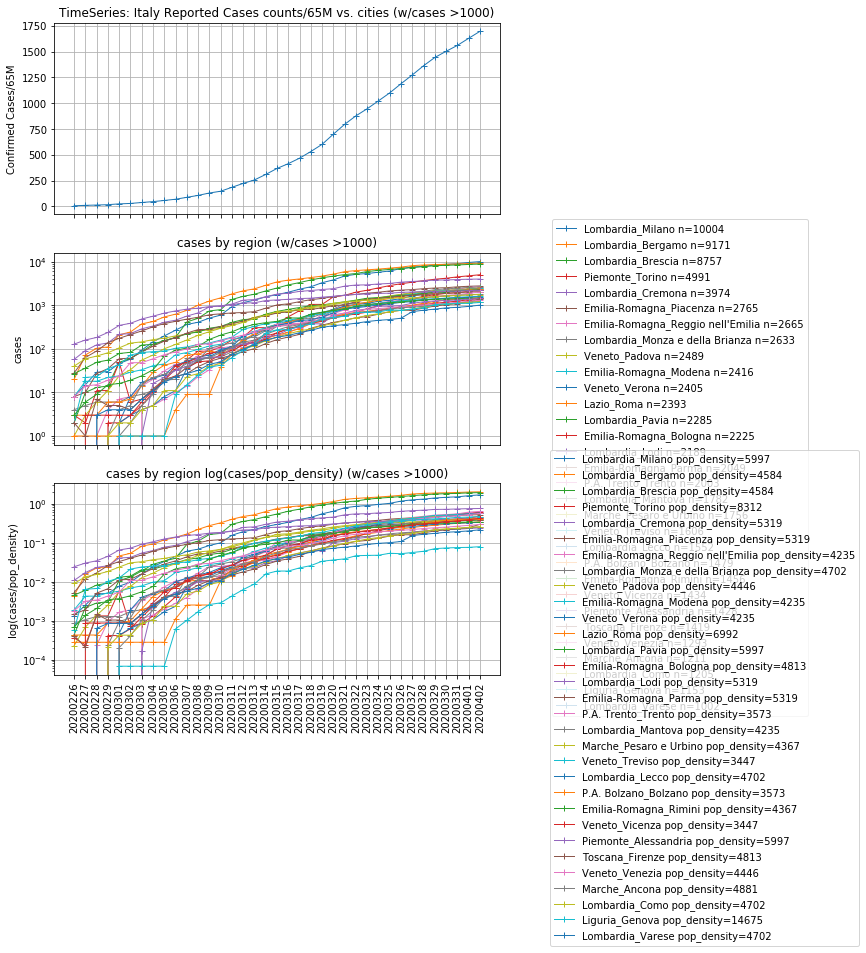

In [13]:
start_pnt=-40;end_point=-3;report_thresh=1000;country_sqrkm=301340

lineLst=df.index

fig, axs = plt.subplots(3, sharex=True, figsize=(8,12))
#fig.suptitle('TimeSeries: Italy Reported Cases counts vs. cities (w/cases >%i)'%report_thresh)
plt.xticks(rotation=90)
st='total_counts';st_sum=df.loc[st]['row_max']
axs[0].plot( df.columns[start_pnt:-3], df.loc[st][start_pnt:end_point]/65, marker='+', linewidth=1, label='%s n=%i'%(st, st_sum))
axs[0].grid(True)
axs[0].set_ylabel('Confirmed Cases/65M')
axs[0].set_title('TimeSeries: Italy Reported Cases counts/65M vs. cities (w/cases >%i)'%report_thresh)

axs[1].set_title('cases by region (w/cases >%i)'%report_thresh)
axs[1].set_ylabel('cases')
axs[1].grid(True)
axs[1].set_yscale('log')
for st in lineLst:
    if st=='total_counts': continue
    x=df.loc[st]
    st_max=x['row_max']
    if x.row_max<report_thresh:continue
    axs[1].plot( df.columns[start_pnt:end_point], 
                df.loc[st][start_pnt:end_point], 
                marker='+', linewidth=1, label='%s n=%i'%(st, st_max))
axs[1].legend(loc='best', bbox_to_anchor=(1.2, 0.7, 0.5, 0.5))

axs[2].set_title('cases by region log(cases/pop_density) (w/cases >%i)'%report_thresh)
axs[2].set_ylabel('log(cases/pop_density)')
axs[2].grid(True)
axs[2].set_yscale('log')
for st in lineLst:
    if st=='total_counts': continue
    x=df.loc[st]
    st_max=x['row_max']
    if x.row_max<report_thresh:continue
    pop_density=df.loc[st]['pop_density']
    axs[2].plot( df.columns[start_pnt:end_point], 
                df.loc[st][start_pnt:end_point]/pop_density,#*country_sqrkm, 
                marker='+', linewidth=1, label='%s pop_density=%i'%(st, pop_density))
axs[2].legend(loc='best', bbox_to_anchor=(1.1, 0.7, 0.5, 0.5))




Here I plotted final infections/pop_density against percent_aged_over65
It does this really explain the High rates n sparse regions?

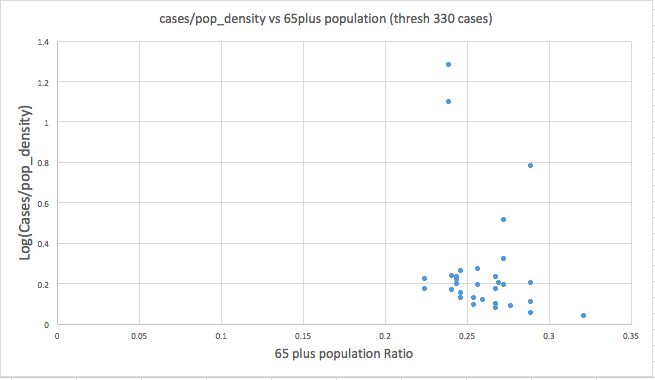


In [ ]:
import numpy as np
import pylab
from scipy.optimize import curve_fit

def sigmoid(x, a, b):
     y = 1 / (1 + np.exp(-b*(x-a)))
     return y

xdata = np.array([400, 600, 800, 1000, 1200, 1400, 1600])
ydata = np.array([0, 0, 0.13, 0.35, 0.75, 0.89, 0.91])

if None:
    st='Lombardia_Bergamo';end_point=-3
    xdata = np.array(range(len(df.columns[start_pnt:-3])))
    ydata = df.loc[st][start_pnt:end_point]

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

popt, pcov = curve_fit(fsigmoid, xdata, ydata, method='dogbox', bounds=([0.0, 1.1], [0.01, 1700.]))



x = np.linspace(-1, max(xdata), 1)
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
#pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()

## Deprecation:

In [ ]:
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
kernel = DotProduct()+ WhiteKernel()
kernel=DotProduct()+sklearn.gaussian_process.kernels.DotProduct()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X, y)

s=gpr.score(X, y)
print('score:', s)

print('X', X)
print('y', y)
print('q', rec.long, rec.lat)
qpoint=np.array(X[0])
qpoint=np.array([rec.long, rec.lat])
gpr.predict([qpoint], return_std=False)


from scipy.spatial.distance import cdist
d=cdist([qpoint], X)
print('d', d, np.argmin(d, axis=1))
pop_val=y[np.argmin(cdist([qpoint], X), axis=1)[0]]
pop_val

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Model

st='Lombardia_Bergamo'
t = np.array(range(len(df.columns[start_pnt:-3])))

v = df.loc[st][start_pnt:-3]

def func(t, a, b, alpha):
    return a + b * np.exp(-alpha * t)

# remove first data point, take offset from t
tx = t[1:] - t[0]
vx = v[1:]

# turn your model function into a Model
amodel = Model(func)
# create parameters with initial values.  Note that parameters
# are named from the arguments of your model function.
params = amodel.make_params(a=v[0], b=0, alpha=1.0/(t[-1]-t[0]))

# fit the data to the model with the parameters
result = amodel.fit(vx, params, t=tx)

# print the fit statistics and resulting parameters
print(result.fit_report())

# plot data and fit
plt.plot(t, v, 'o', label='data')
plt.plot(t, result.eval(result.params, t=(t-t[0])), '--', label='fit')
plt.legend()
plt.show()